# Geospatial analysis in Agriculture with Geopandas

In this example, we will work with a file of points that represent the location of plants and a file of polygons of crop fields.

Link: https://drive.google.com/drive/folders/12ZzsEFDmL4EaZCIbrkadIZQtQ3TOCf3s?usp=sharing

We start by installing libraries, connecting to the Drive and importing libraries:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from skimage.filters import threshold_multiotsu
from skimage.measure import label, regionprops
from skimage.morphology import closing, square
from skimage.color import label2rgb
import matplotlib.pyplot as plt
import rasterio
import geopandas as gpd
import pandas as pd
import numpy as np
import os
from rasterio.plot import show
from rasterio.mask import mask
import json
import cv2

Let's present the data:

In [ ]:
path_lotes = '/content/drive/MyDrive/Datasets_AG/Arroz/Lotes.shp'
path_plantas = '/content/drive/MyDrive/Datasets_AG/Arroz/rice.json'

In [ ]:
gdf_lote = gpd.read_file(path_lotes)

In [ ]:
gdf_lote

,id,Lote,geometry
0,1,A,"POLYGON ((218259.378 2658459.971, 218259.885 2..."
1,2,B,"POLYGON ((218282.899 2658434.262, 218258.453 2..."
2,3,C,"POLYGON ((218284.095 2658458.842, 218285.952 2..."
3,4,D,"POLYGON ((218284.113 2658458.901, 218284.165 2..."
4,5,E,"POLYGON ((218309.773 2658482.73, 218317.645 26..."
5,6,F,"POLYGON ((218308.771 2658457.897, 218310.687 2..."
6,7,G,"POLYGON ((218333.718 2658457.091, 218335.593 2..."
7,8,H,"POLYGON ((218333.695 2658457.146, 218333.809 2..."


In [ ]:
gdf_points = gpd.read_file(path_plantas)

In [ ]:
gdf_points

,x,y,geometry
0,218279.216370,2.658441e+06,POINT (218279.216 2658440.617)
1,218279.180563,2.658440e+06,POINT (218279.181 2658439.729)
2,218279.206140,2.658440e+06,POINT (218279.206 2658440.321)
3,218277.794304,2.658441e+06,POINT (218277.794 2658440.985)
4,218279.021987,2.658441e+06,POINT (218279.022 2658440.929)
...,...,...,...
80466,218303.468223,2.658459e+06,POINT (218303.468 2658459.231)
80467,218303.064110,2.658459e+06,POINT (218303.064 2658459.481)
80468,218303.064110,2.658459e+06,POINT (218303.064 2658459.231)
80469,218303.038534,2.658460e+06,POINT (218303.039 2658460.145)


We are going to visualize the points representing plants and the polygons representing the crop fields:

<Axes: >

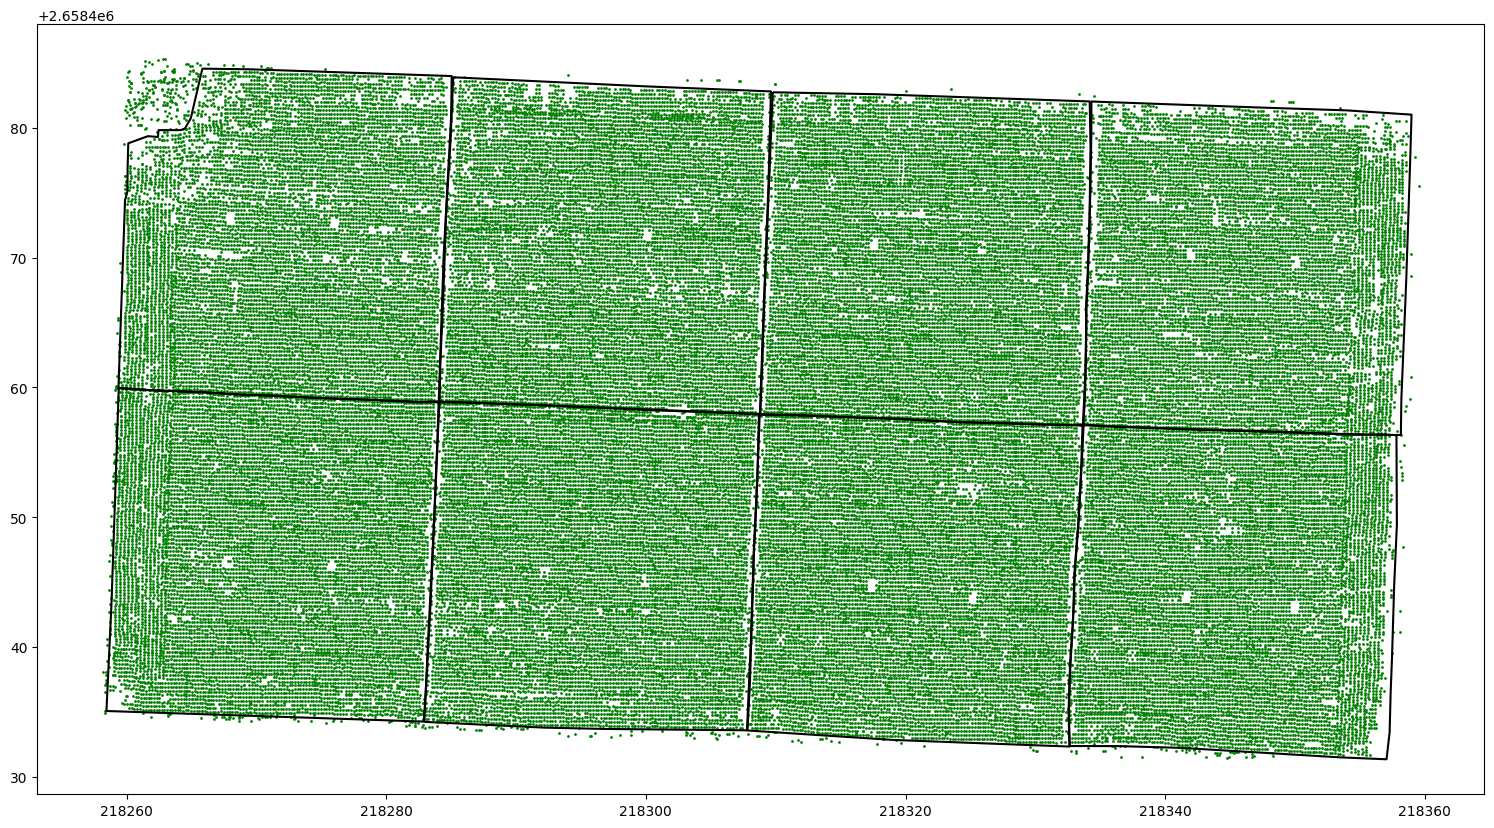

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))
gdf_lote.boundary.plot(ax = ax, color="black")
gdf_points.plot(ax = ax, color='green', markersize = 1)

In [ ]:
gdf_points

,x,y,geometry
0,218279.216370,2.658441e+06,POINT (218279.216 2658440.617)
1,218279.180563,2.658440e+06,POINT (218279.181 2658439.729)
2,218279.206140,2.658440e+06,POINT (218279.206 2658440.321)
3,218277.794304,2.658441e+06,POINT (218277.794 2658440.985)
4,218279.021987,2.658441e+06,POINT (218279.022 2658440.929)
...,...,...,...
80466,218303.468223,2.658459e+06,POINT (218303.468 2658459.231)
80467,218303.064110,2.658459e+06,POINT (218303.064 2658459.481)
80468,218303.064110,2.658459e+06,POINT (218303.064 2658459.231)
80469,218303.038534,2.658460e+06,POINT (218303.039 2658460.145)


In [ ]:
gdf_lote

,id,Lote,geometry
0,1,A,"POLYGON ((218259.378 2658459.971, 218259.885 2..."
1,2,B,"POLYGON ((218282.899 2658434.262, 218258.453 2..."
2,3,C,"POLYGON ((218284.095 2658458.842, 218285.952 2..."
3,4,D,"POLYGON ((218284.113 2658458.901, 218284.165 2..."
4,5,E,"POLYGON ((218309.773 2658482.73, 218317.645 26..."
5,6,F,"POLYGON ((218308.771 2658457.897, 218310.687 2..."
6,7,G,"POLYGON ((218333.718 2658457.091, 218335.593 2..."
7,8,H,"POLYGON ((218333.695 2658457.146, 218333.809 2..."


Let's remove unnecessary columns and apply a spatial join between points and lots:

In [ ]:
gdf_points = gdf_points.drop(columns=['x','y'])

In [ ]:
gdf_points = gdf_points.sjoin(gdf_lote, how='inner',predicate='intersects')

In [ ]:
gdf_points

,geometry,index_right,id,Lote
0,POINT (218279.216 2658440.617),1,2,B
1,POINT (218279.181 2658439.729),1,2,B
2,POINT (218279.206 2658440.321),1,2,B
3,POINT (218277.794 2658440.985),1,2,B
4,POINT (218279.022 2658440.929),1,2,B
...,...,...,...,...
80466,POINT (218303.468 2658459.231),3,4,D
80467,POINT (218303.064 2658459.481),3,4,D
80468,POINT (218303.064 2658459.231),3,4,D
80469,POINT (218303.039 2658460.145),3,4,D


Here we consider the plants to be the same size:

In [ ]:
gdf_points.geometry = gdf_points.geometry.buffer(0.01)

In [ ]:
gdf_points['area'] = gdf_points.geometry.area

In [ ]:
gdf_points

,geometry,index_right,id,Lote,area
0,"POLYGON ((218279.226 2658440.617, 218279.226 2...",1,2,B,0.000314
1,"POLYGON ((218279.191 2658439.729, 218279.191 2...",1,2,B,0.000314
2,"POLYGON ((218279.216 2658440.321, 218279.216 2...",1,2,B,0.000314
3,"POLYGON ((218277.804 2658440.985, 218277.804 2...",1,2,B,0.000314
4,"POLYGON ((218279.032 2658440.929, 218279.032 2...",1,2,B,0.000314
...,...,...,...,...,...
80466,"POLYGON ((218303.478 2658459.231, 218303.478 2...",3,4,D,0.000314
80467,"POLYGON ((218303.074 2658459.481, 218303.074 2...",3,4,D,0.000314
80468,"POLYGON ((218303.074 2658459.231, 218303.074 2...",3,4,D,0.000314
80469,"POLYGON ((218303.049 2658460.145, 218303.048 2...",3,4,D,0.000314


Now let's perform a batch analysis. Let's find the number of plants per batch. To do this, we group the number of plants in each batch.

In [ ]:
df_count = gdf_points[['Lote','id']].groupby('Lote').count()

In [ ]:
df_count

,id
Lote,
A,8835
B,10284
C,10549
D,10075
E,10347
F,10760
G,9874
H,9092


In [ ]:
df_count = df_count.rename(columns={'id':'Quantidade'})

In [ ]:
df_count

,Quantidade
Lote,
A,8835
B,10284
C,10549
D,10075
E,10347
F,10760
G,9874
H,9092


In [ ]:
df_sum = gdf_points[['Lote', 'area']].groupby('Lote').sum()

In [ ]:
df_sum

,area
Lote,
A,2.771141
B,3.225626
C,3.308745
D,3.160073
E,3.245387
F,3.374926
G,3.097028
H,2.851750


In [ ]:
df_sum = df_sum.rename(columns={'area':'area_plantas'})

Let's apply a combination to the Count Dataframe and the Area Sum Dataframe:

In [ ]:
gdf_lote = gdf_lote.merge(df_count, how='inner', on='Lote' )
gdf_lote = gdf_lote.merge(df_sum, how='inner', on='Lote' )

In [ ]:
gdf_lote

,id,Lote,geometry,Quantidade,area_plantas
0,1,A,"POLYGON ((218259.378 2658459.971, 218259.885 2...",8835,2.771141
1,2,B,"POLYGON ((218282.899 2658434.262, 218258.453 2...",10284,3.225626
2,3,C,"POLYGON ((218284.095 2658458.842, 218285.952 2...",10549,3.308745
3,4,D,"POLYGON ((218284.113 2658458.901, 218284.165 2...",10075,3.160073
4,5,E,"POLYGON ((218309.773 2658482.73, 218317.645 26...",10347,3.245387
5,6,F,"POLYGON ((218308.771 2658457.897, 218310.687 2...",10760,3.374926
6,7,G,"POLYGON ((218333.718 2658457.091, 218335.593 2...",9874,3.097028
7,8,H,"POLYGON ((218333.695 2658457.146, 218333.809 2...",9092,2.851750


In [ ]:
gdf_lote['area_lote'] = gdf_lote.geometry.area

In [ ]:
gdf_lote['Densidade de plantas'] = gdf_lote['Quantidade']/gdf_lote['area_lote']

In [ ]:
gdf_lote

,id,Lote,geometry,Quantidade,area_plantas,area_lote,Densidade de plantas
0,1,A,"POLYGON ((218259.378 2658459.971, 218259.885 2...",8835,2.771141,592.634784,14.908001
1,2,B,"POLYGON ((218282.899 2658434.262, 218258.453 2...",10284,3.225626,606.704242,16.950598
2,3,C,"POLYGON ((218284.095 2658458.842, 218285.952 2...",10549,3.308745,609.856944,17.297499
3,4,D,"POLYGON ((218284.113 2658458.901, 218284.165 2...",10075,3.160073,614.035635,16.407843
4,5,E,"POLYGON ((218309.773 2658482.73, 218317.645 26...",10347,3.245387,617.455795,16.757475
5,6,F,"POLYGON ((218308.771 2658457.897, 218310.687 2...",10760,3.374926,609.562482,17.652005
6,7,G,"POLYGON ((218333.718 2658457.091, 218335.593 2...",9874,3.097028,606.332141,16.284804
7,8,H,"POLYGON ((218333.695 2658457.146, 218333.809 2...",9092,2.851750,610.462702,14.893621


Let's present the polygons using the columns we generated as properties:

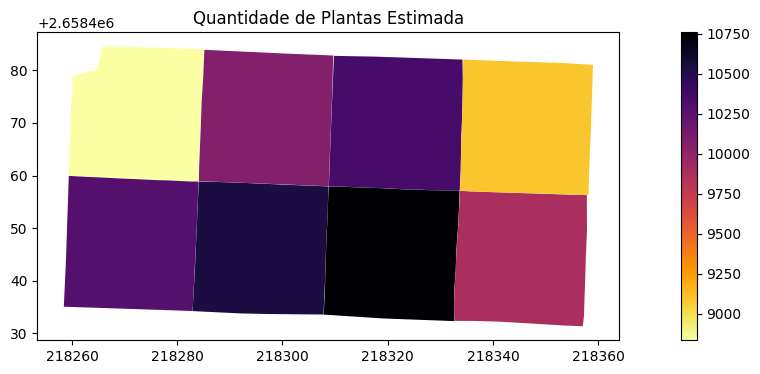

In [ ]:
fig, ax = plt.subplots(figsize=(16,4))
gdf_lote.plot("Quantidade",legend=True, cmap='inferno_r',ax = ax)
ax.title.set_text('Quantidade de Plantas Estimada')

We will also present the estimated total leaf area:

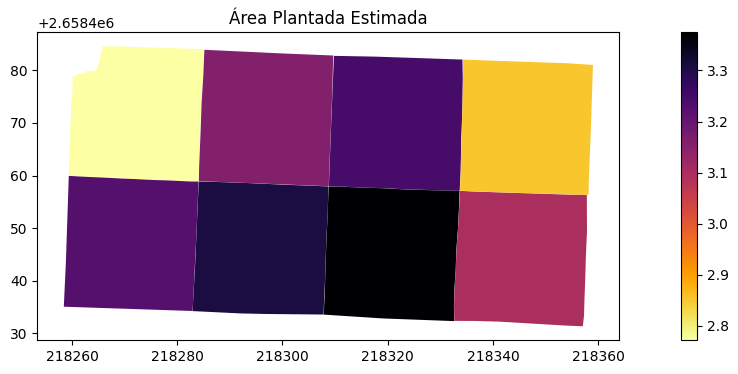

In [ ]:
fig, ax = plt.subplots(figsize=(16,4))
gdf_lote.plot("area_plantas",legend=True, cmap='inferno_r',ax = ax)
ax.title.set_text('Área Plantada Estimada')

And finally, we will present the density of plants per field:

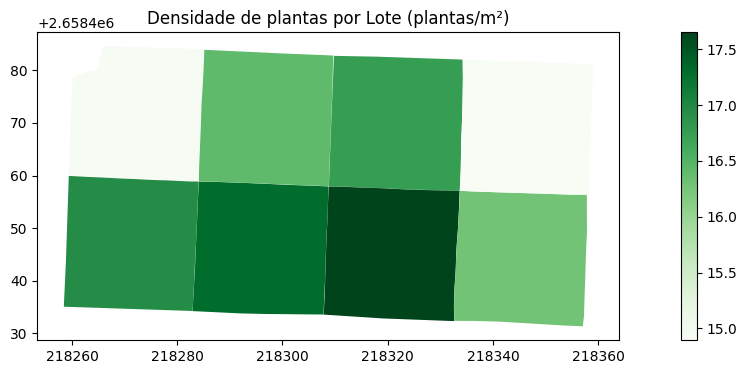

In [ ]:
fig, ax = plt.subplots(figsize=(16,4))
gdf_lote.plot("Densidade de plantas",legend=True, cmap='Greens',ax = ax)
ax.title.set_text('Densidade de plantas por Lote (plantas/m²)')